✅ Font 'Helvetica' loaded successfully.
✅ Figure saved as: income_mean_age_rmse_coverage_width.pdf


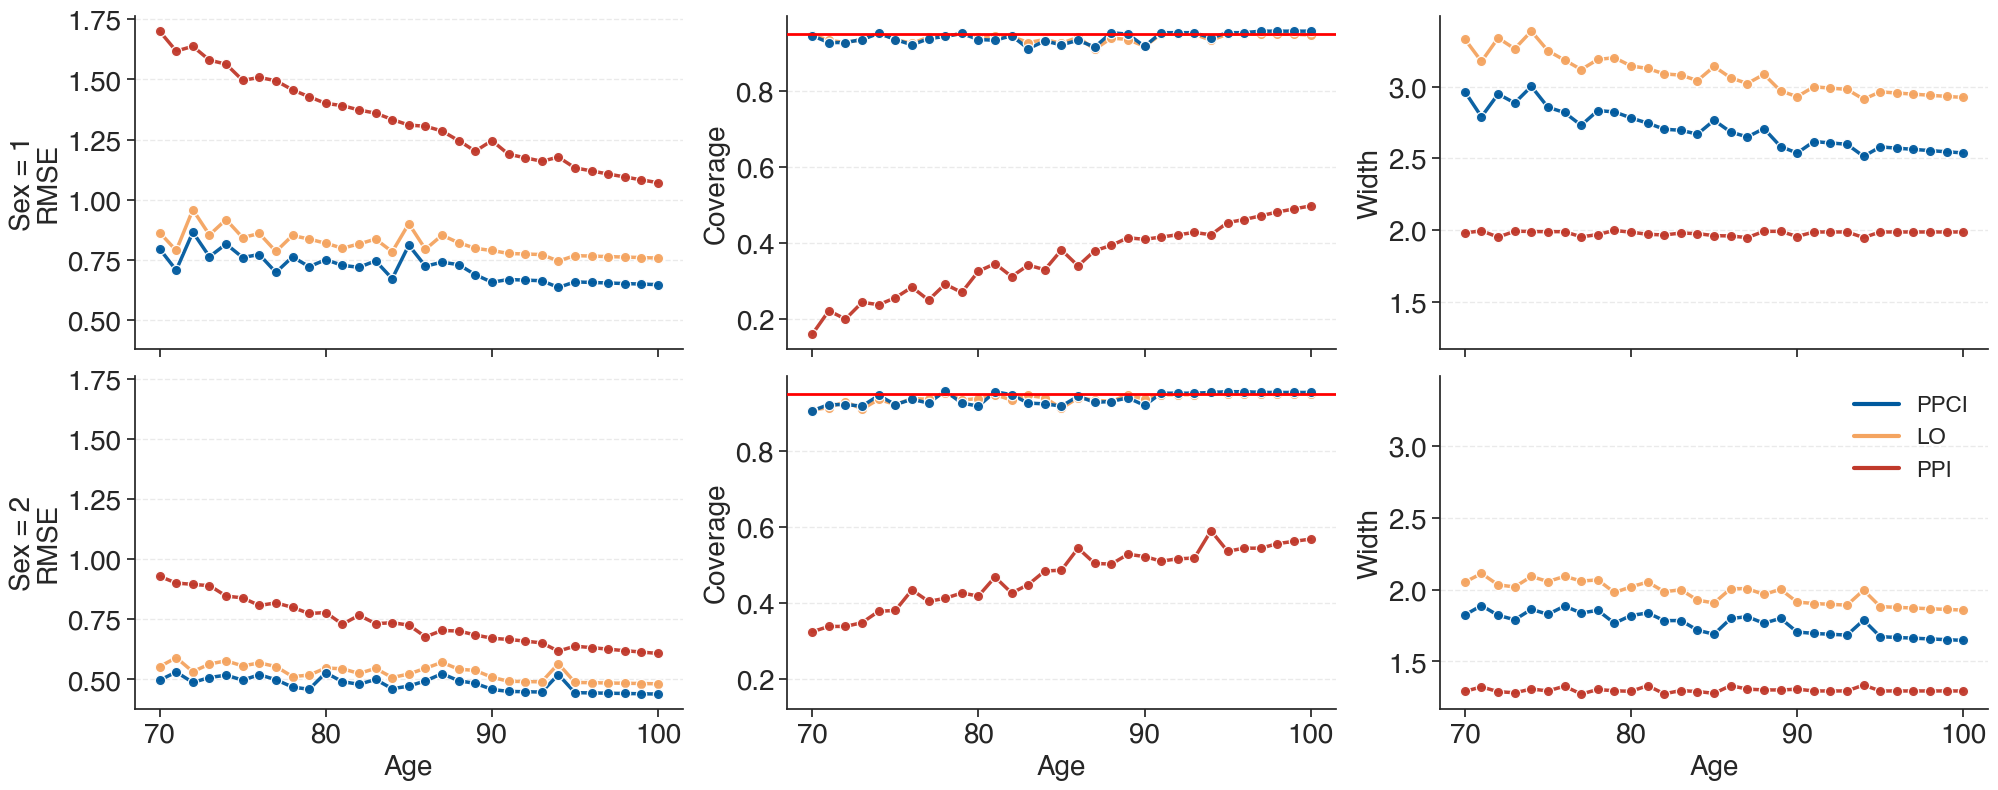

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import numpy as np
from matplotlib.lines import Line2D

# ==========================================
# 0. Font & plotting style configuration (force Helvetica)
# ==========================================
FONT_SIZE = 20
font_path = '/home/ysui8/yangsuienv/Helvetica.ttf'
custom_font_name = "Helvetica"  # Assume loaded successfully

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        if prop.get_name() != 'Helvetica':
            raise ValueError("Loaded font name mismatch")
        print(f"✅ Font 'Helvetica' loaded successfully.")
    except Exception as e:
        raise FileNotFoundError(
            f"❌ Unable to load Helvetica font file '{font_path}'. Please ensure the path is correct and the file is valid."
        )
else:
    raise FileNotFoundError(f"❌ Helvetica font file '{font_path}' not found. Please check the path.")

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [custom_font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = custom_font_name
mpl.rcParams['mathtext.it'] = f'{custom_font_name}:italic'
mpl.rcParams['mathtext.bf'] = f'{custom_font_name}:bold'

sns.set_theme(
    style="ticks",
    rc={
        "axes.grid": False,   # Disable global grid first; manually enable only horizontal grid later
        "font.sans-serif": [custom_font_name],
    },
)

# ==========================================
# 1. Read data: directly read the CSV generated by run_census_income_ppci_mean.py
# ==========================================
# Replace with your actual path, e.g., "./results/census_income_ppci_mean_all_x0.csv"
filename = "./results/census_income_ppci_mean_all_x0.csv"
df = pd.read_csv(filename)

# Check required columns
required_cols = [
    "age", "sex",
    "PPCI_theta_rmse", "PPCI_coverage", "PPCI_avg_ci_width",
    "PPCILO_theta_rmse", "PPCILO_coverage", "PPCILO_avg_ci_width",
    "PPI_theta_rmse", "PPI_coverage", "PPI_avg_ci_width",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CSV is missing these columns: {missing}")

df["age"] = df["age"].astype(int)
df["sex"] = df["sex"].astype(int)

# ==========================================
# 2. Convert to long format: Method × Metric
# ==========================================
plot_data = []
for _, row in df.iterrows():
    age = int(row["age"])
    sex = int(row["sex"])

    # PPCI
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "RMSE",     "Value": float(row["PPCI_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "Coverage", "Value": float(row["PPCI_coverage"])},
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "Width",    "Value": float(row["PPCI_avg_ci_width"])},
    ]

    # LO (label-only)
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "RMSE",     "Value": float(row["PPCILO_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "Coverage", "Value": float(row["PPCILO_coverage"])},
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "Width",    "Value": float(row["PPCILO_avg_ci_width"])},
    ]

    # PPI
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "RMSE",     "Value": float(row["PPI_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "Coverage", "Value": float(row["PPI_coverage"])},
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "Width",    "Value": float(row["PPI_avg_ci_width"])},
    ]

df_long = pd.DataFrame(plot_data)

# ==========================================
# 3. Colors & smoothing function & plotting order
# ==========================================
palette = {
    "PPCI": "#005a9e",  # blue
    "LO":   "#f4a460",  # orange (reuse your NW color)
    "PPI":  "#c0392b",  # red
}

# Plot order: draw LO first and PPCI last so PPCI points are on top
methods_plot = ["LO", "PPI", "PPCI"]
methods_legend = ["PPCI", "LO", "PPI"]

zorder_line = {"LO": 1, "PPI": 2, "PPCI": 3}
zorder_scatter = {"LO": 4, "PPI": 5, "PPCI": 6}

def smooth_line(x, y, num=200):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) <= 1:
        return x, y
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), num=num)
    y_new = np.interp(x_new, x_sorted, y_sorted)
    return x_new, y_new

metrics = ["RMSE", "Coverage", "Width"]

# ==========================================
# 4. 2×3: rows = Sex(1/2), cols = RMSE/Coverage/Width
# ==========================================
fig, axes = plt.subplots(
    2, 3,
    figsize=(20, 8),
    sharex='col',
    sharey='col'
)

for r, sex in enumerate([1, 2]):
    # Row label: put Sex on the left side of the first panel in the row
    axes[r, 0].text(
        -0.18, 0.5,
        f"Sex = {sex}",
        transform=axes[r, 0].transAxes,
        rotation=90,
        va="center",
        ha="right",
        fontsize=FONT_SIZE,
    )

    sub_sex = df_long[df_long["Sex"] == sex]

    for c, metric in enumerate(metrics):
        ax = axes[r, c]
        sub_metric = sub_sex[sub_sex["Metric"] == metric]

        for method in methods_plot:
            sub = sub_metric[sub_metric["Method"] == method].copy()
            if sub.empty:
                continue

            sub = sub.sort_values("Age")
            x = sub["Age"].values
            y = sub["Value"].values

            x_s, y_s = smooth_line(x, y, num=200)

            ax.plot(
                x_s, y_s,
                color=palette[method],
                linewidth=2.5,
                alpha=0.95,
                zorder=zorder_line[method],
            )
            ax.scatter(
                x, y,
                color=palette[method],
                marker="o",
                s=55,
                alpha=0.95,
                edgecolors="white",
                linewidths=0.9,
                zorder=zorder_scatter[method],
            )

        # Only draw y=0.95 red line in the Coverage panel, and keep it on top
        if metric == "Coverage":
            ax.axhline(
                0.95,
                color="red",
                linestyle="-",
                linewidth=2,
                zorder=10,
            )

        ax.set_ylabel(metric, fontsize=FONT_SIZE)
        ax.tick_params(axis='both', labelsize=FONT_SIZE)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(custom_font_name)

# Only add x-label to the bottom row
for c in range(3):
    axes[1, c].set_xlabel("Age", fontsize=FONT_SIZE)
    for label in axes[1, c].get_xticklabels():
        label.set_fontname(custom_font_name)

# ==========================================
# 5. Axis styling: keep only x/y spines + horizontal dashed gridlines only
# ==========================================
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.xaxis.grid(False)

# ==========================================
# 6. Legend: place it in the bottom-right panel (Sex=2, Width), upper-right corner, vertical
# ==========================================
method_handles = [
    Line2D([0], [0], color=palette[m], linewidth=3, label=m)
    for m in methods_legend
]

axes[1, 2].legend(
    handles=method_handles,
    loc="upper right",
    fontsize=FONT_SIZE-4,
    frameon=False,
)

plt.tight_layout()
output_file = "income_mean_age_rmse_coverage_width.pdf"
plt.savefig(output_file, bbox_inches='tight', dpi=400)
print(f"✅ Figure saved as: {output_file}")
plt.show()


✅ Font 'Helvetica' loaded successfully.


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


✅ Figure saved as: income_mean_age_sigma2_two_sex_cmr_math.pdf


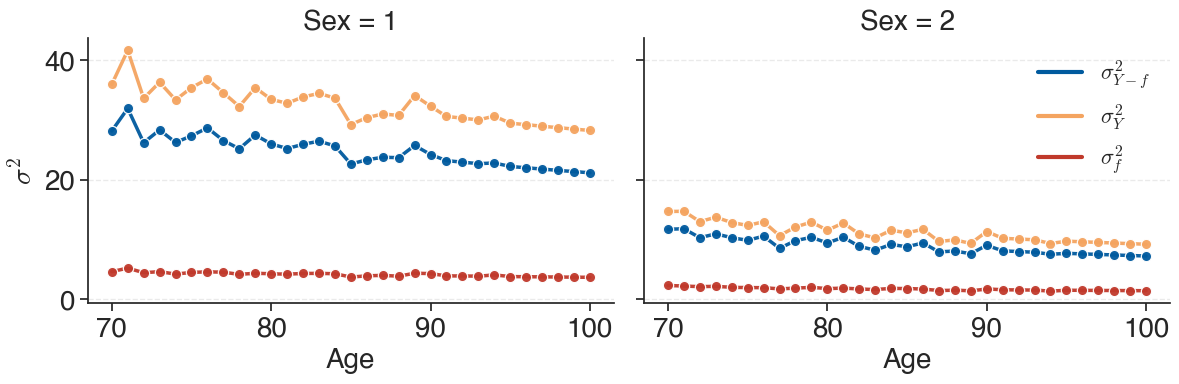

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import numpy as np
from matplotlib.lines import Line2D

# ==========================================
# 0. Font & plotting style configuration
#    - Regular text: Helvetica
#    - Math text: Computer Modern (CMR) style
# ==========================================
FONT_SIZE = 20
font_path = '/home/ysui8/yangsuienv/Helvetica.ttf'
custom_font_name = "Helvetica"

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        if prop.get_name() != 'Helvetica':
            raise ValueError("Loaded font name mismatch")
        print(f"✅ Font 'Helvetica' loaded successfully.")
    except Exception:
        raise FileNotFoundError(
            f"❌ Unable to load Helvetica font file '{font_path}'. Please ensure the path is correct and the file is valid."
        )
else:
    raise FileNotFoundError(f"❌ Helvetica font file '{font_path}' not found. Please check the path.")

# Regular text uses Helvetica
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [custom_font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# ✅ Math text uses CMR (no external LaTeX dependency)
mpl.rcParams["mathtext.fontset"] = "cm"

sns.set_theme(
    style="ticks",
    rc={
        "axes.grid": False,
        "font.sans-serif": [custom_font_name],
    },
)

# ==========================================
# 1. Read data: census income results CSV
# ==========================================
filename = "./results/census_income_ppci_mean_all_x0.csv"
df = pd.read_csv(filename)

required_cols = [
    "age", "sex",
    "PPCI_sigma2_Y_minus_A_mean",
    "PPCI_sigma2_A_mean",
    "PPCILO_sigma2_Y_mean",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CSV is missing these columns: {missing}")

df["age"] = df["age"].astype(int)
df["sex"] = df["sex"].astype(int)

# ==========================================
# 2. LaTeX (math) labels + colors
# ==========================================
label_YmA = r"$\sigma^2_{Y-f}$"
label_Y   = r"$\sigma^2_Y$"
label_A   = r"$\sigma^2_f$"

palette = {
    label_YmA: "#005a9e",  # blue
    label_Y:   "#f4a460",  # orange
    label_A:   "#c0392b",  # red
}

# Plot order: orange first, then red, and blue last (so blue points are on top)
series_plot = [label_Y, label_A, label_YmA]
series_legend = [label_YmA, label_Y, label_A]

zorder_line = {label_Y: 1, label_A: 2, label_YmA: 3}
zorder_scatter = {label_Y: 4, label_A: 5, label_YmA: 6}

def smooth_line(x, y, num=200):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) <= 1:
        return x, y
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), num=num)
    y_new = np.interp(x_new, x_sorted, y_sorted)
    return x_new, y_new

# ==========================================
# 3. One row with two panels: Sex=1 / Sex=2
# ==========================================
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 4),
    sharey=True
)

for j, sex in enumerate([1, 2]):
    ax = axes[j]
    sub = df[df["sex"] == sex].sort_values("age")
    if sub.empty:
        raise ValueError(f"❌ No data for sex={sex}.")

    x = sub["age"].values

    for name in series_plot:
        if name == label_YmA:
            y = sub["PPCI_sigma2_Y_minus_A_mean"].values
        elif name == label_A:
            y = sub["PPCI_sigma2_A_mean"].values
        elif name == label_Y:
            y = sub["PPCILO_sigma2_Y_mean"].values
        else:
            continue

        x_s, y_s = smooth_line(x, y, num=200)

        ax.plot(
            x_s, y_s,
            color=palette[name],
            linewidth=2.5,
            alpha=0.95,
            zorder=zorder_line[name],
        )
        ax.scatter(
            x, y,
            color=palette[name],
            marker="o",
            s=55,
            alpha=0.95,
            edgecolors="white",
            linewidths=0.9,
            zorder=zorder_scatter[name],
        )

    ax.set_title(f"Sex = {sex}", fontsize=FONT_SIZE)
    ax.set_xlabel("Age", fontsize=FONT_SIZE)
    ax.tick_params(axis='both', labelsize=FONT_SIZE)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname(custom_font_name)

# Unified y-axis label (math is CMR)
axes[0].set_ylabel(r"$\sigma^2$", fontsize=FONT_SIZE)
for label in axes[0].get_yticklabels():
    label.set_fontname(custom_font_name)

# ==========================================
# 4. Axis styling: keep only x/y spines + horizontal dashed gridlines only
# ==========================================
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.xaxis.grid(False)

# ==========================================
# 5. Legend: place it at the upper right of the right panel (math is CMR)
# ==========================================
handles = [
    Line2D([0], [0], color=palette[name], linewidth=3, label=name)
    for name in series_legend
]
axes[1].legend(
    handles=handles,
    loc="upper right",
    fontsize=FONT_SIZE-4,
    frameon=False,
)

plt.tight_layout()
output_file = "income_mean_age_sigma2_two_sex_cmr_math.pdf"
plt.savefig(output_file, bbox_inches='tight', dpi=400)
print(f"✅ Figure saved as: {output_file}")
plt.show()

✅ Font 'Helvetica' loaded successfully.
✅ Figure saved as: income_quantile_age_rmse_coverage_width.pdf


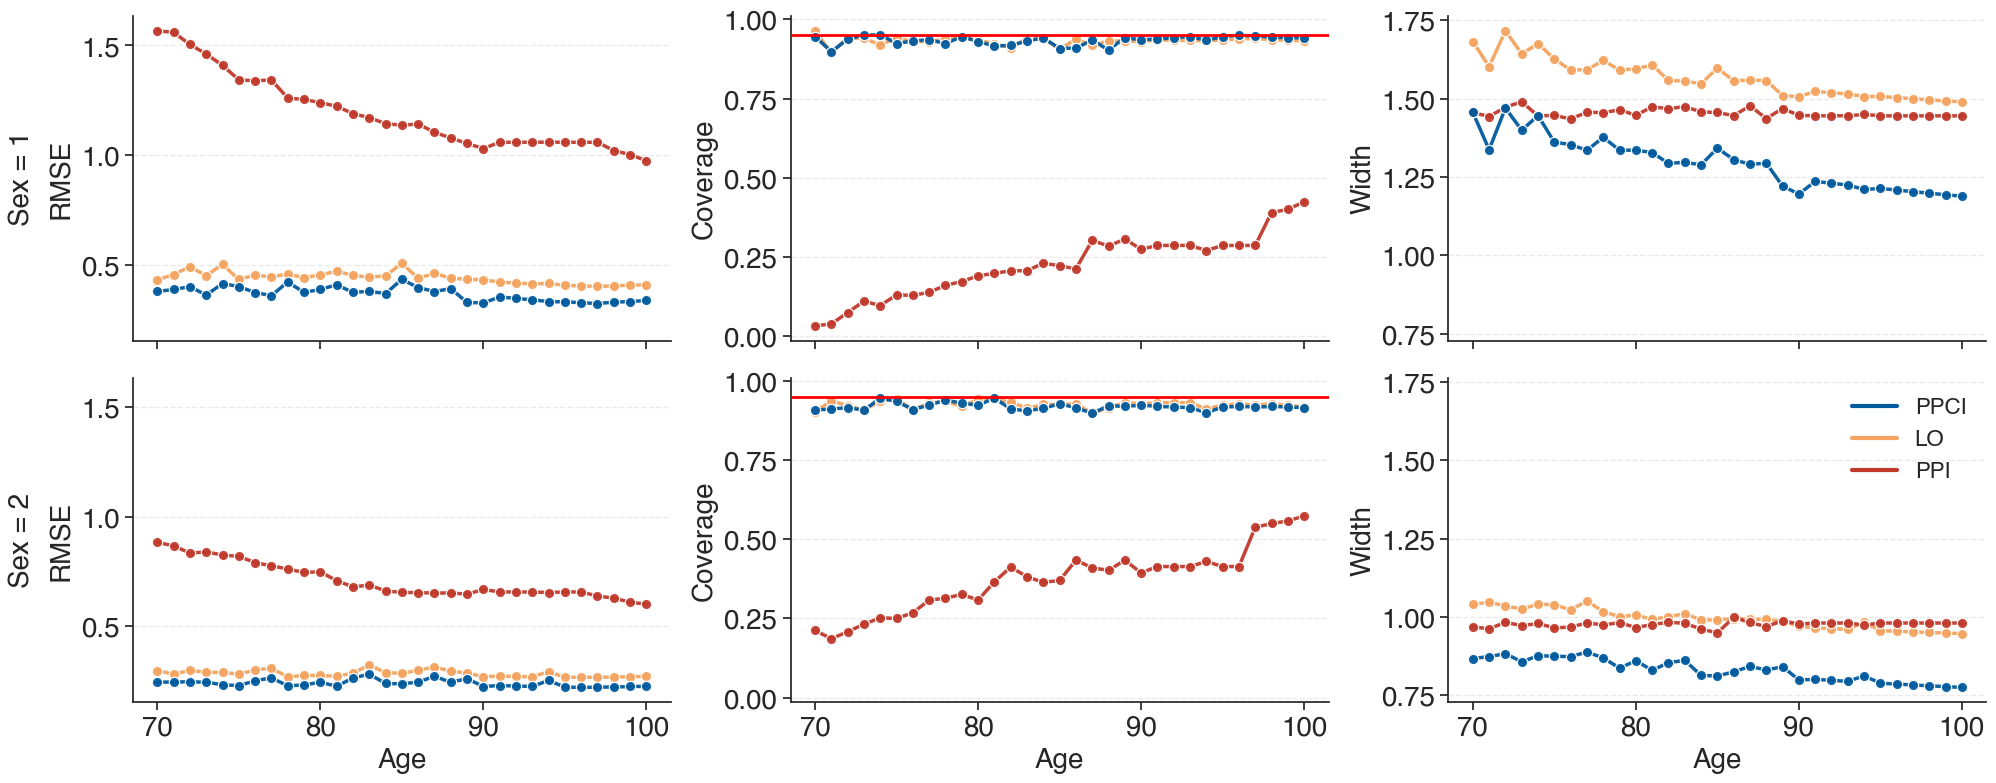

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import numpy as np
from matplotlib.lines import Line2D

# ==========================================
# 0. Font & plotting style configuration (force Helvetica)
# ==========================================
FONT_SIZE = 20
font_path = '/home/ysui8/yangsuienv/Helvetica.ttf'
custom_font_name = "Helvetica"  # Assume loaded successfully

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        if prop.get_name() != 'Helvetica':
            raise ValueError("Loaded font name mismatch")
        print(f"✅ Font 'Helvetica' loaded successfully.")
    except Exception as e:
        raise FileNotFoundError(
            f"❌ Unable to load Helvetica font file '{font_path}'. Please ensure the path is correct and the file is valid."
        )
else:
    raise FileNotFoundError(f"❌ Helvetica font file '{font_path}' not found. Please check the path.")

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [custom_font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = custom_font_name
mpl.rcParams['mathtext.it'] = f'{custom_font_name}:italic'
mpl.rcParams['mathtext.bf'] = f'{custom_font_name}:bold'

sns.set_theme(
    style="ticks",
    rc={
        "axes.grid": False,   # Disable global grid first; manually enable only horizontal grid later
        "font.sans-serif": [custom_font_name],
    },
)

# ==========================================
# 1. Read data: directly read the CSV generated by run_census_income_ppci_mean.py
# ==========================================
# Replace with your actual path, e.g., "./results/census_income_ppci_mean_all_x0.csv"
filename = "./results/census_income_ppci_quantile_all_x0.csv"
df = pd.read_csv(filename)

# Basic column check
required_cols = [
    "age", "sex",
    "PPCI_theta_rmse", "PPCI_coverage", "PPCI_avg_ci_width",
    "PPCILO_theta_rmse", "PPCILO_coverage", "PPCILO_avg_ci_width",
    "PPI_theta_rmse", "PPI_coverage", "PPI_avg_ci_width",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CSV is missing these columns: {missing}")

df["age"] = df["age"].astype(int)
df["sex"] = df["sex"].astype(int)

# ==========================================
# 2. Convert to long format: Method × Metric
# ==========================================
plot_data = []
for _, row in df.iterrows():
    age = int(row["age"])
    sex = int(row["sex"])

    # PPCI
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "RMSE",     "Value": float(row["PPCI_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "Coverage", "Value": float(row["PPCI_coverage"])},
        {"Age": age, "Sex": sex, "Method": "PPCI", "Metric": "Width",    "Value": float(row["PPCI_avg_ci_width"])},
    ]

    # LO (label-only)
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "RMSE",     "Value": float(row["PPCILO_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "Coverage", "Value": float(row["PPCILO_coverage"])},
        {"Age": age, "Sex": sex, "Method": "LO", "Metric": "Width",    "Value": float(row["PPCILO_avg_ci_width"])},
    ]

    # PPI
    plot_data += [
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "RMSE",     "Value": float(row["PPI_theta_rmse"])},
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "Coverage", "Value": float(row["PPI_coverage"])},
        {"Age": age, "Sex": sex, "Method": "PPI", "Metric": "Width",    "Value": float(row["PPI_avg_ci_width"])},
    ]

df_long = pd.DataFrame(plot_data)

# ==========================================
# 3. Colors & smoothing function & plotting order
# ==========================================
palette = {
    "PPCI": "#005a9e",  # blue
    "LO":   "#f4a460",  # orange (reuse your NW color)
    "PPI":  "#c0392b",  # red
}

# Plot order: draw LO first and PPCI last so PPCI points are on top
methods_plot = ["LO", "PPI", "PPCI"]
methods_legend = ["PPCI", "LO", "PPI"]

zorder_line = {"LO": 1, "PPI": 2, "PPCI": 3}
zorder_scatter = {"LO": 4, "PPI": 5, "PPCI": 6}

def smooth_line(x, y, num=200):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) <= 1:
        return x, y
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), num=num)
    y_new = np.interp(x_new, x_sorted, y_sorted)
    return x_new, y_new

metrics = ["RMSE", "Coverage", "Width"]

# ==========================================
# 4. 2×3: rows = Sex(1/2), cols = RMSE/Coverage/Width
# ==========================================
fig, axes = plt.subplots(
    2, 3,
    figsize=(20, 8),
    sharex='col',
    sharey='col'
)

for r, sex in enumerate([1, 2]):
    # Row label: place Sex on the left side of the first panel in the row
    axes[r, 0].text(
        -0.18, 0.5,
        f"Sex = {sex}",
        transform=axes[r, 0].transAxes,
        rotation=90,
        va="center",
        ha="right",
        fontsize=FONT_SIZE,
    )

    sub_sex = df_long[df_long["Sex"] == sex]

    for c, metric in enumerate(metrics):
        ax = axes[r, c]
        sub_metric = sub_sex[sub_sex["Metric"] == metric]

        for method in methods_plot:
            sub = sub_metric[sub_metric["Method"] == method].copy()
            if sub.empty:
                continue

            sub = sub.sort_values("Age")
            x = sub["Age"].values
            y = sub["Value"].values

            x_s, y_s = smooth_line(x, y, num=200)

            ax.plot(
                x_s, y_s,
                color=palette[method],
                linewidth=2.5,
                alpha=0.95,
                zorder=zorder_line[method],
            )
            ax.scatter(
                x, y,
                color=palette[method],
                marker="o",
                s=55,
                alpha=0.95,
                edgecolors="white",
                linewidths=0.9,
                zorder=zorder_scatter[method],
            )

        # Only draw the y=0.95 red line in the Coverage panel, and keep it on top
        if metric == "Coverage":
            ax.axhline(
                0.95,
                color="red",
                linestyle="-",
                linewidth=2,
                zorder=10,
            )

        ax.set_ylabel(metric, fontsize=FONT_SIZE)
        ax.tick_params(axis='both', labelsize=FONT_SIZE)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname(custom_font_name)

# Only add x-label to the bottom row
for c in range(3):
    axes[1, c].set_xlabel("Age", fontsize=FONT_SIZE)
    for label in axes[1, c].get_xticklabels():
        label.set_fontname(custom_font_name)

# ==========================================
# 5. Axis styling: keep only x/y spines + horizontal dashed gridlines only
# ==========================================
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.xaxis.grid(False)

# ==========================================
# 6. Legend: place it in the bottom-right panel (Sex=2, Width), upper-right corner, vertical
# ==========================================
method_handles = [
    Line2D([0], [0], color=palette[m], linewidth=3, label=m)
    for m in methods_legend
]

axes[1, 2].legend(
    handles=method_handles,
    loc="upper right",
    fontsize=FONT_SIZE-4,
    frameon=False,
)

plt.tight_layout()
output_file = "income_quantile_age_rmse_coverage_width.pdf"
plt.savefig(output_file, bbox_inches='tight', dpi=400)
print(f"✅ Figure saved as: {output_file}")
plt.show()